Source: https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html

In [7]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
import numpy as np

from PIL import ImageDraw

plt.ion()   # interactive mode

In [4]:
# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../../data/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../../data/', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

100.1%Extracting ../../data/MNIST\raw\train-images-idx3-ubyte.gz to ../../data/MNIST\raw
113.5%Extracting ../../data/MNIST\raw\train-labels-idx1-ubyte.gz to ../../data/MNIST\raw
100.4%Extracting ../../data/MNIST\raw\t10k-images-idx3-ubyte.gz to ../../data/MNIST\raw
180.4%Extracting ../../data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ../../data/MNIST\raw
Processing...
Done!


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # input is single channel, deepen here
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        # Two FC layers to classify
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # ST localization network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    # This also allows for the localization to be called separately on test data
    def stn(self, x):
        theta = self.theta(x)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def theta(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        return theta        

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.cuda()
        target = target.cuda()

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target) # negative log-likelihood
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data = data.cuda()
            target = target.cuda()
            
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

In [12]:
model = Net().cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01)
for epoch in range(21):
    train(epoch)
    test()
    print('-'*20)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.352391
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.982114

Test set: Average loss: 0.3656, Accuracy: 8901/10000 (89%)

--------------------
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.639017
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.485768

Test set: Average loss: 0.1291, Accuracy: 9607/10000 (96%)

--------------------
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.320729
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.321718

Test set: Average loss: 0.1050, Accuracy: 9666/10000 (97%)

--------------------
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.387873
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.435946

Test set: Average loss: 0.1566, Accuracy: 9521/10000 (95%)

--------------------
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.170377
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.225875

Test set: Average loss: 0.0816, Accuracy: 9748/10000 (97%)

--------------------
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.075230
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.069890

Test set: Average l

In [4]:
def convert_image_np(image):
    """Convert a Tensor to numpy image."""
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    return image

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.

def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].cuda()

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

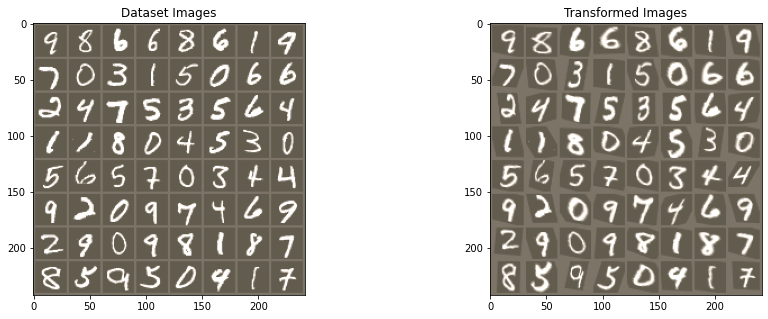

In [18]:
visualize_stn()

This is pretty boring though... there was no transformations applied to the digits in the first place. Let's spice it up by applying a random translation, and see if our model can localize the digits from the translated one.

In [10]:
random_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../../data/', train=False, transform=transforms.Compose([
        transforms.Pad(22),
        transforms.RandomAffine(0, translate=(0.4, 0.4)),
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

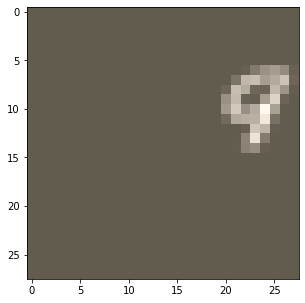

In [202]:
single_image = next(iter(random_loader))[0].cpu()[0,:,:,:]
plt.imshow(convert_image_np(single_image), cmap='binary')

In [6]:
def visualize_stn_random():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(random_loader))[0].cuda()

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

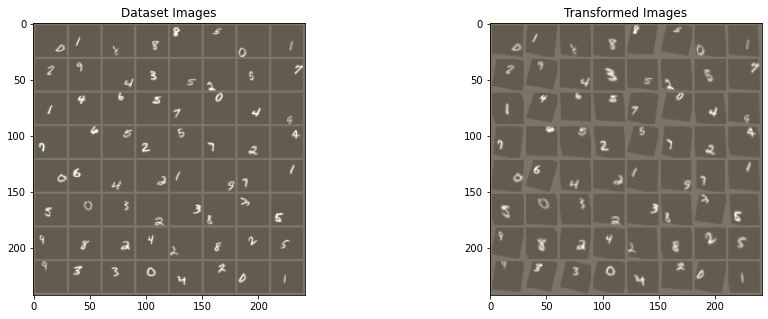

In [203]:
visualize_stn_random()

It seems that the model fails to "find" the digit. Let's try retraining with the random transform applied to the test and train set

In [7]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../../data/', train=True, transform=transforms.Compose([
        transforms.Pad(22),
        transforms.RandomAffine(0, translate=(0.4, 0.4)),
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../../data/', train=False, transform=transforms.Compose([
        transforms.Pad(22),
        transforms.RandomAffine(0, translate=(0.4, 0.4)),
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

In [89]:
model = Net().cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01)
for epoch in range(35):
    train(epoch)
    test()
    print('-'*20)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.324570
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.291516

Test set: Average loss: 2.2995, Accuracy: 1336/10000 (13%)

--------------------
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308444
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.293184

Test set: Average loss: 2.2918, Accuracy: 1577/10000 (16%)

--------------------
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.288330
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.281097

Test set: Average loss: 2.2648, Accuracy: 1712/10000 (17%)

--------------------
Train Epoch: 3 [0/60000 (0%)]	Loss: 2.273394
Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.233794

Test set: Average loss: 2.2036, Accuracy: 1911/10000 (19%)

--------------------
Train Epoch: 4 [0/60000 (0%)]	Loss: 2.226053
Train Epoch: 4 [32000/60000 (53%)]	Loss: 2.189004

Test set: Average loss: 2.1372, Accuracy: 2120/10000 (21%)

--------------------
Train Epoch: 5 [0/60000 (0%)]	Loss: 2.154883
Train Epoch: 5 [32000/60000 (53%)]	Loss: 2.123564

Test set: Average l

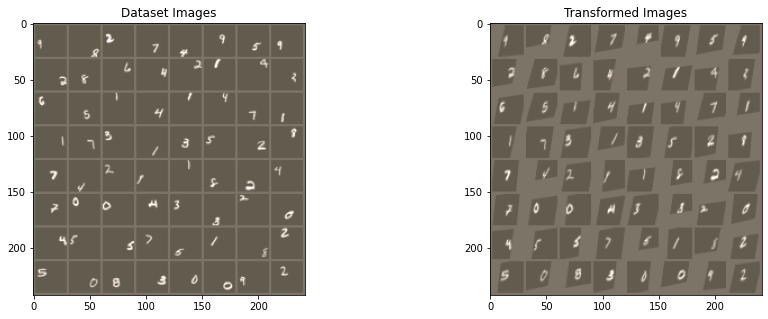

In [90]:
visualize_stn_random()

Now, the digits are each positioned in about the same place (centered in the image). This caused the test accuracy to increase also!

## Trying to draw the bounding box on the original image

In [19]:
single_batch = next(iter(random_loader))[0].cuda()

In [20]:
with torch.no_grad():
    thetas = model.theta(single_batch)
theta = thetas.cpu()[0]


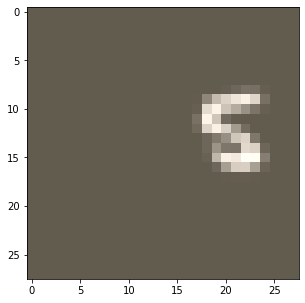

In [21]:
single_image = single_batch[0,:,:,:].cpu()
plt.imshow(convert_image_np(single_image))

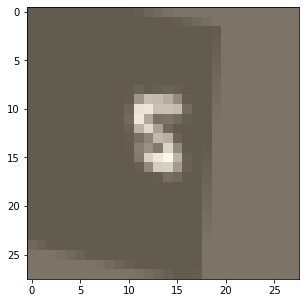

In [22]:
with torch.no_grad():
    tformed_single_batch = model.stn(single_batch)
tformed_single_img = tformed_single_batch[0,:,:,:].cpu()
plt.imshow(convert_image_np(tformed_single_img))

Using pen and paper, solve for (x1, y1), (x2, y2), the coordinates of the corners of the transformed image in the original image space.
 
See: https://stackoverflow.com/questions/55373014/how-to-use-spatial-transformer-to-crop-the-image-in-pytorch


In [23]:
tx = theta[0][-1]
ty = theta[-1][-1]
a = theta[0][0]
b = theta[1][1]
w = 28
h = 28

x1 = (w*(tx + 1 - a))/2
x2 = a*w + x1
y1 = (h*(ty + 1 - b))/2
y2 = b*h + y1

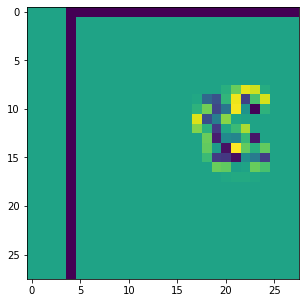

In [24]:
single_pil = transforms.ToPILImage()(single_image)
draw = ImageDraw.Draw(single_pil)
draw.rectangle([x1, y1, x2, y2])
plt.imshow(single_pil)

After reading documentation, I realize that I can use the torch function `affine_grid` to get normalized image coordinates from source image:

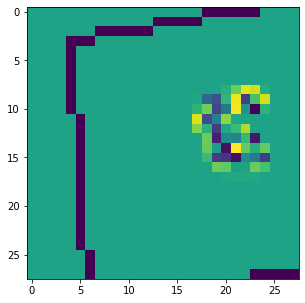

In [84]:
grid = F.affine_grid(theta.view(1, 2, 3), torch.Size([1, *single_image.size()]))
grid = 28*(grid[0] + 1) / 2 # undo normalization of image coordinates
single_pil = transforms.ToPILImage()(single_image)
draw = ImageDraw.Draw(single_pil)
draw.line([*grid[0][0], *grid[0][27]])
draw.line([*grid[0][27], *grid[27][27]])
draw.line([*grid[27][27], *grid[27][0]])
draw.line([*grid[27][0], *grid[0][0]])
plt.imshow(single_pil)

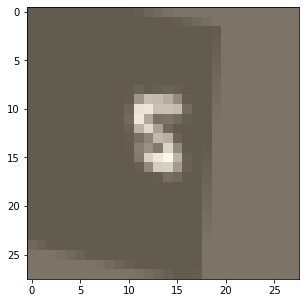

In [81]:
plt.imshow(convert_image_np(tformed_single_img))

It is hard to tell if this is working right, but it looks to be ~ correct. I will need to spend some more time on this.

NOTE: See stn_downsample for a more thorough investigation into this

## Rotations

In [337]:
random_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../../data/', train=False, transform=transforms.Compose([
        transforms.RandomAffine(120),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

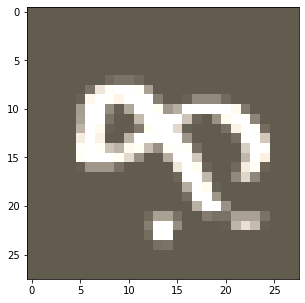

In [338]:
single_image = next(iter(random_loader))[0].cpu()[0,:,:,:]
plt.imshow(convert_image_np(single_image), cmap='binary')

Again, curious to see if the model already knows how to rotate the digits from last training

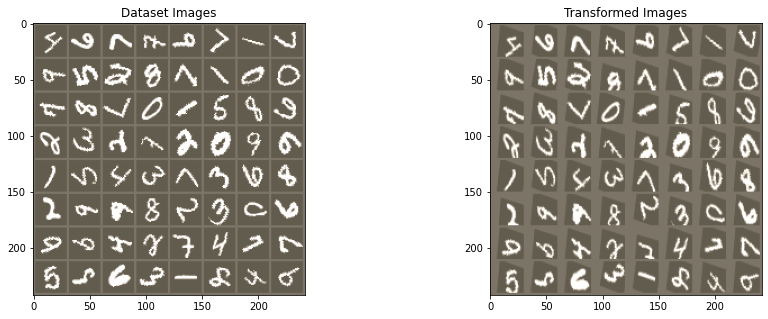

In [339]:
visualize_stn_random()

Retrain

In [5]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../../data/', train=True, transform=transforms.Compose([
        transforms.RandomAffine(120),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../../data/', train=False, transform=transforms.Compose([
        transforms.RandomAffine(120),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

In [9]:
model = Net().cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01)
for epoch in range(51):
    train(epoch)
    test()
    print('-'*20)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.348995
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.167761

Test set: Average loss: 1.6047, Accuracy: 4697/10000 (47%)

--------------------
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.820924
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.964857

Test set: Average loss: 1.1051, Accuracy: 6520/10000 (65%)

--------------------
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.515184
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.287424

Test set: Average loss: 0.6960, Accuracy: 7958/10000 (80%)

--------------------
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.656863
Train Epoch: 3 [32000/60000 (53%)]	Loss: 1.029018

Test set: Average loss: 0.5593, Accuracy: 8343/10000 (83%)

--------------------
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.936882
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.892818

Test set: Average loss: 0.4995, Accuracy: 8495/10000 (85%)

--------------------
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.907976
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.771776

Test set: Average l

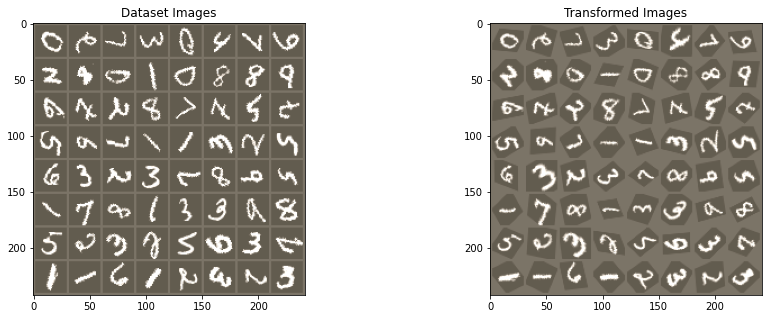

In [10]:
visualize_stn()

For some reason, the digits were not straightend as expected. Howver, the test accuracy did increase. Becuase the rotation does not seem to be corrected for, it is possible that this is because the model generalized on its own, without any help needed from the transformer. A few ideas to get this to work:
- Change the model to be simply fully connected, instead of having convolutions
- Try to use thin plate spline

Thinking about it some more, it could simply be because the mean of the data is not an upright digit. In fact, looking at the top right corner of the visualization, the upright 8's got transformerd to be sideways, so it may be that this is the optimal position for the net.